In [95]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from synthid_text.detector_frequentist import frequentist_score, weighted_frequentist_score
import matplotlib.pyplot as plt
import torch
import numpy as np
from matplotlib.patches import Rectangle
from scipy.stats import norm


In [ ]:
MODEL_NAMES = ["google/gemma-2b-it", "google/gemma-7b-it", "mistralai/Mistral-7B-Instruct-v0.3", "meta-llama/Llama-3.1-8B-Instruct", "ISTA-DASLab/Meta-Llama-3.1-70B-Instruct-AQLM-PV-2Bit-1x16"]
F_MODEL_NAMES =  [name.replace("/", "_") for name in MODEL_NAMES]
TEMPERATURE = 0.5
TOKEN_LIMIT = 200 # set to -1 to use full responses
USE_WEIGHTED = True

score = frequentist_score if not USE_WEIGHTED else weighted_frequentist_score

In [97]:
padded_eli5_g_values = [torch.load(f"../frequentist_experiment_data/eli5_g_values_{F_MODEL_NAME}_t={TEMPERATURE}_wm.pt", map_location=torch.device('cpu')) for F_MODEL_NAME in F_MODEL_NAMES]
padded_eli5_combined_mask = [torch.load(f"../frequentist_experiment_data/eli5_combined_mask_{F_MODEL_NAME}_t={TEMPERATURE}_wm.pt", map_location=torch.device('cpu')) for F_MODEL_NAME in F_MODEL_NAMES]
eli5_perplexities = [torch.load(f"../frequentist_experiment_data/eli5_perplexities_{F_MODEL_NAME}_t={TEMPERATURE}_wm.pt", map_location=torch.device('cpu')) for F_MODEL_NAME in F_MODEL_NAMES]

/var/folders/59/7skhmmps2b17ysy_h9b099zh0000gn/T/ipykernel_92975/376284043.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  padded_eli5_g_values = [torch.load(f"../freque

In [98]:
freq_scores = [score(padded_eli5_g_values[i].cpu().numpy()[:,:TOKEN_LIMIT,:], padded_eli5_combined_mask[i].cpu().numpy()[:,:TOKEN_LIMIT]) for i in range(len(MODEL_NAMES))]

In [99]:
# Mean Response Lengths
avg_seq_lens = [torch.mean(torch.sum(padded_eli5_combined_mask[i], dim=1).double()).item() for i in range(len(MODEL_NAMES))]

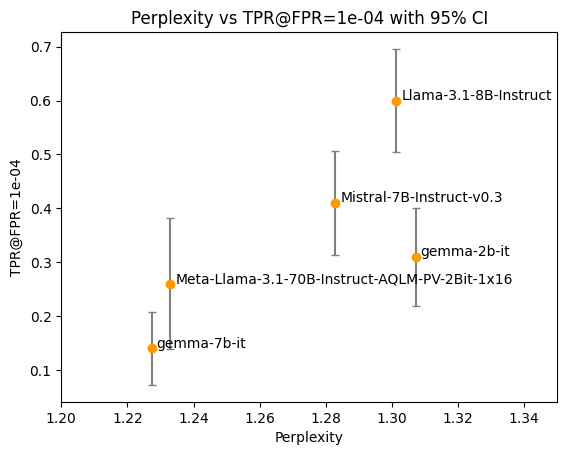

In [100]:
FPR = 1e-4
FPR_STR = '{:.0e}'.format(FPR)

# Compute perplexities
perplexities = [
    torch.exp(torch.tensor(np.sum(eli5_perplexities[i])) / len(padded_eli5_g_values[i])).item() 
    for i in range(len(MODEL_NAMES))
]

# Compute TPR (with threshold condition)
tpr = [np.sum(-freq_scores[i] <= FPR) / len(freq_scores[i]) for i in range(len(MODEL_NAMES))]

# Compute 95% Confidence Intervals
z = norm.ppf(0.975) # 1.96 approximately

std_err_tpr = []
for i in range(len(MODEL_NAMES)):
    p = tpr[i]
    n = len(freq_scores[i])  # total number of samples for that model
    # Standard error for a proportion
    std_err = np.sqrt(p * (1 - p) / n)
    std_err_tpr.append(std_err)

perplexities = np.array(perplexities)
tpr = np.array(tpr)
std_err_tpr = np.array(std_err_tpr)

# Compute upper and lower bounds of the CI
tpr_lower = tpr - z * std_err_tpr
tpr_upper = tpr + z * std_err_tpr

fig, ax = plt.subplots()

# Plot points with error bars
ax.errorbar(perplexities, tpr, yerr=[tpr - tpr_lower, tpr_upper - tpr],
            fmt='o', color='#ff9900', ecolor='gray', capsize=3)

# Annotate points with model names
for i, txt in enumerate(MODEL_NAMES):
    label_txt = txt[txt.index('/')+1:] if '/' in txt else txt
    ax.annotate(label_txt, (perplexities[i] + 0.0015, tpr[i] + 0.0015))

plt.xlim(1.2, 1.35)
plt.ylabel(f"TPR@FPR={FPR_STR}")
plt.xlabel("Perplexity")
plt.title(f"Perplexity vs TPR@FPR={FPR_STR} with 95% CI" + ("" if USE_WEIGHTED else " (unweighted)") + (f" (max {TOKEN_LIMIT} tokens)" if TOKEN_LIMIT > 0 else ""))

plt.show()
